# 准备阶段

## 数据集描述

* 该数据集取自现金贷用户最后一个申请通过事件。<br>

* 时间：2018年1月1号~2018年2月10号 <br>

* **数据列**需要注意的地方：

  * initialamount：授信金额，单位是分
  * 列名均为小写



## 加载依赖的块和库

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn import preprocessing
from scipy.stats import skew, boxcox
import os

from pyecharts import Bar
import mpld3
from mpld3 import plugins

%matplotlib inline

# 探索性数据分析(EDA)及可视化

In [4]:
# 定义异常值范围
na_values=['','NULL','NA','null','na','Na','-9999','Infinity','NaN']
xpath='D:\\\xc8\xd5\xb3\xa3\xb7\xd6\xce\xf6\xb1\xa8\xb8\xe6\\\xb3\xac\xd0\xa1\xb6\xee\xb7\xd6\xce\xf6\\'
# 读取数据集
data_set_name=pd.read_table(xpath+'data\\data_set_name.txt',header=None,sep='\t',na_values = na_values)
data_set=pd.read_table(xpath+'data\\data_set.txt',header=None,sep='\t',na_values = na_values,names=data_set_name[0],index_col=None)

# 查看数据集信息
print('---------------------------------------数据预览：---------------------------------------------')
print(data_set.head())

print('---------------------------------------数据集基本信息：---------------------------------------')
print(data_set.info())

print('---------------------------------------数据统计信息：-----------------------------------------')
print(data_set.describe())

---------------------------------------数据预览：---------------------------------------------
          bid      apply_time  dt_month  is_white  due_days  min_due_dt  \
0  1962201492  20180107064639    201801         0       NaN         NaN   
1  1716258201  20180119085050    201801         0       NaN         NaN   
2  2136678708  20180106180326    201801         1       0.0  2018-02-07   
3  2134606407  20180118031016    201801         1       0.0  2018-02-18   
4  1961531724  20180124120647    201801         1       NaN         NaN   

     action_bid  city_idx  age  jiedaiscore      ...       riscode  \
0           NaN       NaN   28          9.0      ...         10000   
1           NaN       NaN   35          NaN      ...         10000   
2  2.136679e+09       NaN   30         61.0      ...         10000   
3  2.134606e+09       NaN   31         29.0      ...         10000   
4           NaN       NaN   28         12.0      ...         10000   

        reasoncode  zxcreditretcode  e

## 数据处理

### 聚合分类变量

In [5]:
# 申请城市city_idx聚合为1线城市，2线城市，3线城市及其他
data_set.loc[data_set.city_idx==1.0,'city_index_cut']='1_city'
data_set.loc[data_set.city_idx==1.5,'city_index_cut']='2_city'
data_set.loc[data_set.city_idx==2.0,'city_index_cut']='3_city'
data_set.loc[(data_set.city_idx!=1.0) & (data_set.city_idx!=1.5) & (data_set.city_idx!=2.0),'city_index_cut']='4_city'

# 构建新变量，并按照索引排序
data_set['city_index_cut'].value_counts(dropna=False).sort_index()

1_city    154029
2_city    236914
3_city    225717
4_city    466720
Name: city_index_cut, dtype: int64

### 离散化数值型变量

In [6]:
# age
age_bins=[0,18,22,28,35,45,55,np.inf]
age_group_names=range(1,len(age_bins))
cats=pd.cut(list(data_set['age']),age_bins,right = False,labels=age_group_names) # right=False 表示左闭口右开
data_set['age_cut']=list(cats)

# 同盾和百度多头
duotou_vars=['jiedaiscore','bidnormalscoreexp3v2','prcidnormalscoreexp3v2','phonenormalscoreexp3v2']
duotou_bins=[0,20,40,60,80,100]
duotou_group_name=range(1,len(duotou_bins))
for col in duotou_vars:
    cats=pd.cut(list(data_set[col]),duotou_bins,right = False,labels=duotou_group_name)
    data_set[str(col)+'_'+'cut']=list(cats)


# 手机入网时长 mobileOperatorRegDate
mobile_bins=[0,10,20,30,40,np.inf]
mobile_group_name=range(1,len(mobile_bins))
cats=pd.cut(list(data_set['mobileoperatorregdate']),mobile_bins,right=False,labels=mobile_group_name)
data_set['mobileoperatorregdate_cut']=list(cats)


# 征信
zx_vars=['zxaccountcnt','zxhouseloancnt']
zx_bins=[-np.inf,1,5,10,np.inf]
zx_group_name=range(1,len(zx_bins))
for col in zx_vars:
    cats=pd.cut(list(data_set[col]),zx_bins,right=False,labels=zx_group_name)
    data_set[str(col)+'_'+'cut']=list(cats)
    

# preaficoscorev5
prea_bins=[0,480,520,550,600,650,np.inf]
pre_group_name=range(1,len(prea_bins))
cats=pd.cut(list(data_set['preaficoscorev5']),prea_bins,right=False,labels=pre_group_name)
data_set['preaficoscorev5_cut']=list(cats)



In [23]:
# 概览
data_set[['preaficoscorev5','preaficoscorev5_cut','zxaccountcnt','zxaccountcnt_cut','age','age_cut']].head()

,preaficoscorev5,preaficoscorev5_cut,zxaccountcnt,zxaccountcnt_cut,age,age_cut
0,NaN,NaN,20.0,4.0,28,4
1,583.0,4.0,2.0,2.0,35,5
2,594.0,4.0,17.0,4.0,30,4
3,589.0,4.0,7.0,3.0,31,4
4,567.0,4.0,7.0,3.0,28,4


### 构建逻辑变量

In [7]:
# 判断用户是否用信：due_days大于等于0，表示用户用信
action=[]
for i in range(len(data_set)):
    if data_set['due_days'][i]>=0:
        action.append(1)
    else :
        action.append(0)

data_set['action']=action

In [8]:
#  判断是否逾期用户
odu_bid=[]
for i in range(len(data_set)):
    if data_set['due_days'][i]>0:
        odu_bid.append(1)
    else :
        odu_bid.append(0)

data_set['odu_bid']=odu_bid

In [9]:
# 判断是否是超小额用户
petty_bid=[]
for i in range(len(data_set)):
    if data_set['initialamount'][i] == 50000:
        petty_bid.append(1)
    else :
        petty_bid.append(0)

data_set['petty_bid']=petty_bid

In [10]:
# 判断是否是用信超小额用户
action_petty_bid=[]
for i in range(len(data_set)):
    if data_set['initialamount'][i] == 50000 and data_set['due_days'][i]>=0:
        action_petty_bid.append(1)
    else :
        action_petty_bid.append(0)

data_set['action_petty_bid']=action_petty_bid

In [11]:
# 构建白名单和超小额组合字段
data_set.loc[data_set.is_white==1,'white_petty_bid']='A'
data_set.loc[(data_set.is_white==0)&(data_set.petty_bid==0),'white_petty_bid']='B'
data_set.loc[(data_set.is_white==0)&(data_set.petty_bid==1),'white_petty_bid']='C'

### 基本数据概览

In [12]:
white_petty_grouped = data_set.groupby('white_petty_bid')
# 迭代groupby对象
for group, frame in white_petty_grouped:
    apply_sum = frame['bid'].count()
    action_sum = frame['action'].sum()
    odu_sum = frame['odu_bid'].sum()
    ratio_action=round(frame['action'].sum()*1.0/frame['bid'].count()*100,2)
    ratio_odu=round(frame['odu_bid'].sum()*1.0/frame['action'].sum()*100,2)
    print('{}群体授信人数：{}，用信人数：{}，逾期人数{} , 用信率(%)：{}，逾期率(%)：{}'.format(group, apply_sum, action_sum, odu_sum , ratio_action,ratio_odu))

A群体授信人数：842929，用信人数：466190，逾期人数13397 , 用信率(%)：55.31，逾期率(%)：2.87
B群体授信人数：224933，用信人数：109343，逾期人数5008 , 用信率(%)：48.61，逾期率(%)：4.58
C群体授信人数：15518，用信人数：5543，逾期人数671 , 用信率(%)：35.72，逾期率(%)：12.11


结论1：
* 整体授信群体一共1083380人，用信581076人，逾期19076人。用信率：53.6%，逾期率：3.2%
* 白名单群体用信率和逾期率跟大盘持平
* 非白群体中，超小额群体用信意愿最低，且逾期率也最高，明显高于整体非白群体

## 透视表

* 对于分类型变量，考虑不同组合下，不同群体的分布变化

### 超小额

In [122]:
# 表格：超小额用户群体用信人数和逾期人数
grouped = data_set.groupby(['petty_bid'])
for group, frame in grouped:
    print('超小额为{}的申请用户个数：{}'.format(group, len(frame)))

grouped.agg({'petty_bid':np.sum,'action': np.sum ,'odu_bid':np.sum})

超小额为0的申请用户个数：1067246
超小额为1的申请用户个数：16134


,action,odu_bid,petty_bid
petty_bid,,,
0,575392,18398,0
1,5684,678,16134


### 白名单

In [123]:
# 表格：超小额用户群体用信人数和逾期人数
grouped = data_set.groupby(['is_white'])
for group, frame in grouped:
    print('名单类型为{}的申请用户个数：{}'.format(group, len(frame)))

grouped.agg({'petty_bid':np.sum,'action': np.sum ,'odu_bid':np.sum})

名单类型为0的申请用户个数：240451
名单类型为1的申请用户个数：842929


,action,odu_bid,petty_bid
is_white,,,
0,114886,5679,15518
1,466190,13397,616


### （白名单，超小额）

In [49]:
# 表格：超小额用户群体用信人数和逾期人数
grouped = data_set.groupby(['is_white','petty_bid'])
for group, frame in grouped:
    print('（白名单，超小额）为{}的申请用户个数：{}'.format(group, len(frame)))

grouped.agg({'petty_bid':np.sum,'action': np.sum ,'odu_bid':np.sum})

（白名单，超小额）为(0, 0)的申请用户个数：224933
（白名单，超小额）为(0, 1)的申请用户个数：15518
（白名单，超小额）为(1, 0)的申请用户个数：842313
（白名单，超小额）为(1, 1)的申请用户个数：616


action  odu_bid  petty_bid
is_white petty_bid                            
0        0          109343     5008          0
         1            5543      671      15518
1        0          466049    13390          0
         1             141        7        616

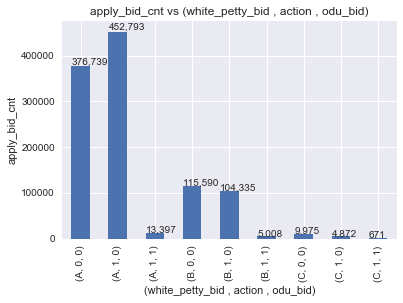

In [112]:
# 作图：三类群体用户和逾期分布
plt.figure()
ax2 = data_set.groupby(['white_petty_bid','action','odu_bid']).size().plot(kind='bar')
ax2.set_title('apply_bid_cnt vs (white_petty_bid , action , odu_bid)')
ax2.set_xlabel('(white_petty_bid , action , odu_bid)')
ax2.set_ylabel('apply_bid_cnt')

# 添加标注
for p in ax2.patches:
    ax2.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))  

由透视表和柱状图可得结论：<br>
* 整体高逾期率主要由非白群体造成：22.2%授信人群占比，29.8%的逾期人数占比
* 虽然超小额群体在非白人群中的逾期与较高11.8%，但是整体人数占比也较低6.7%。

## 数据下钻及可视化

* 分析white_petty_bid群体（细分为A，B，C）的用信和逾期指标在不同 **X特征** 下的分布情况


In [156]:
# 不同目标群体在不同年龄区间的用信和逾期分布
# data_set.pivot_table(values=['bid','action','odu_bid'], index='white_petty_bid', columns='age_cut', aggfunc={"bid":len,"action":np.sum,"odu_bid":np.sum}, margins=True)
data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='age_cut', aggfunc=np.sum, margins=True)

action                                               \
age_cut                2         3         4        5        6      7   
white_petty_bid                                                         
A                35292.0  168395.0  158615.0  82816.0  20587.0  485.0   
B                14134.0   46145.0   32124.0  14471.0   2453.0   16.0   
C                 1730.0    2207.0    1462.0    142.0      2.0    NaN   
All              51156.0  216747.0  192201.0  97429.0  23042.0  501.0   

                          odu_bid                                       \
age_cut               All       2       3       4       5      6     7   
white_petty_bid                                                          
A                466190.0  1623.0  5163.0  3968.0  1932.0  691.0  20.0   
B                109343.0   911.0  2121.0  1249.0   629.0   98.0   0.0   
C                  5543.0   244.0   252.0   157.0    18.0    0.0   NaN   
All              581076.0  2778.0  7536.0  5374.0  2579.0  789.0  20.0   

                          
age_cut              All  
white_petty_bid           
A                13397.0  
B                 5008.0  
C                  671.0  
All              19076.0

In [174]:
# 画堆积图
age_groups=data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='age_cut', aggfunc=np.sum)['odu_bid']
A = age_groups.iloc[0, 0 : 6].values
B = age_groups.iloc[1, 0 : 6].values
C = age_groups.iloc[2, 0 : 6].values
labels = age_groups.index.values.tolist()
age_cut = age_groups.columns.tolist()

bar = Bar("age_cut VS white_petty_bid")
bar.add('白名单', age_cut, A, is_stack=True)
bar.add('非白非小额', age_cut, B, is_stack=True)
bar.add('非白超小额', age_cut, C, is_stack=True)
bar

结论：<br>
* 超小额群体的逾期人群主要分布在18~22岁年龄段,31.2%的用信群体贡献了36.4%的逾期人群

In [162]:
#不同目标群体在不同地区的用信和逾期分布
data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='city_index_cut', aggfunc=np.sum, margins=True)

action                                         odu_bid  \
city_index_cut    1_city    2_city    3_city    4_city       All  1_city   
white_petty_bid                                                            
A                66531.0  103705.0   98016.0  197938.0  466190.0  1617.0   
B                13425.0   23484.0   22344.0   50090.0  109343.0   460.0   
C                  534.0     911.0     961.0    3137.0    5543.0    63.0   
All              80490.0  128100.0  121321.0  251165.0  581076.0  2140.0   

                                                  
city_index_cut   2_city  3_city  4_city      All  
white_petty_bid                                   
A                2885.0  2745.0  6150.0  13397.0  
B                1091.0  1036.0  2421.0   5008.0  
C                 118.0    89.0   401.0    671.0  
All              4094.0  3870.0  8972.0  19076.0

In [175]:
# 画堆积图
city_groups=data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='city_index_cut', aggfunc=np.sum)['action']
A = city_groups.iloc[0, 0 : city_groups.shape[1]].values
B = city_groups.iloc[1, 0 : city_groups.shape[1]].values
C = city_groups.iloc[2, 0 : city_groups.shape[1]].values
labels = city_groups.index.values.tolist()
city_idx = city_groups.columns.tolist()

bar = Bar("city_idx VS white_petty_bid")
bar.add('白名单', city_idx, A, is_stack=True)
bar.add('非白非小额', city_idx, B, is_stack=True)
bar.add('非白超小额', city_idx, C, is_stack=True)
bar

In [200]:
# 不同目标群体在不同X特征下的用信和逾期分布
# 同盾黑名单
tongdunblacklevel=data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='tongdunblacklevel', aggfunc=np.sum, margins=True)

# prcid分
prcidnormalscoreexp3v2_cut=data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='prcidnormalscoreexp3v2_cut', aggfunc=np.sum, margins=True)

# 学历
education=data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='education', aggfunc=np.sum, margins=True)

# 手机入网时长
mobileoperatorregdate_cut=data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='mobileoperatorregdate_cut', aggfunc=np.sum, margins=True)

# 借贷分
jiedaiscore_cut=data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='jiedaiscore_cut', aggfunc=np.sum, margins=True)

# preA
preacustseg=data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='preacustseg', aggfunc=np.sum, margins=True)

# preA_V5
preaficoscorev5_cut=data_set.pivot_table(values=['action','odu_bid'], index='white_petty_bid', columns='preaficoscorev5_cut', aggfunc=np.sum, margins=True)


In [201]:
print('不同目标群体在不同X特征下的用信和逾期分布 : ')
preaficoscorev5_cut

不同目标群体在不同X特征下的用信和逾期分布 : 


action                                               \
preaficoscorev5_cut    1.0     2.0       3.0       4.0      5.0     6.0   
white_petty_bid                                                           
A                      0.0  1484.0   61236.0  342329.0  59041.0  1617.0   
B                     89.0  7346.0   51585.0   36261.0   4759.0   163.0   
C                      9.0   680.0    1351.0     372.0     21.0     1.0   
All                   98.0  9510.0  114172.0  378962.0  63821.0  1781.0   

                              odu_bid                                      \
preaficoscorev5_cut       All     1.0    2.0     3.0      4.0    5.0  6.0   
white_petty_bid                                                             
A                    465707.0     0.0  131.0  3025.0   9469.0  742.0  8.0   
B                    100203.0     9.0  580.0  2594.0   1337.0   53.0  1.0   
C                      2434.0     1.0   74.0   108.0     29.0    0.0  0.0   
All                  568344.0    10.0  785.0  5727.0  10835.0  795.0  9.0   

                              
preaficoscorev5_cut      All  
white_petty_bid               
A                    13375.0  
B                     4574.0  
C                      212.0  
All                  18161.0

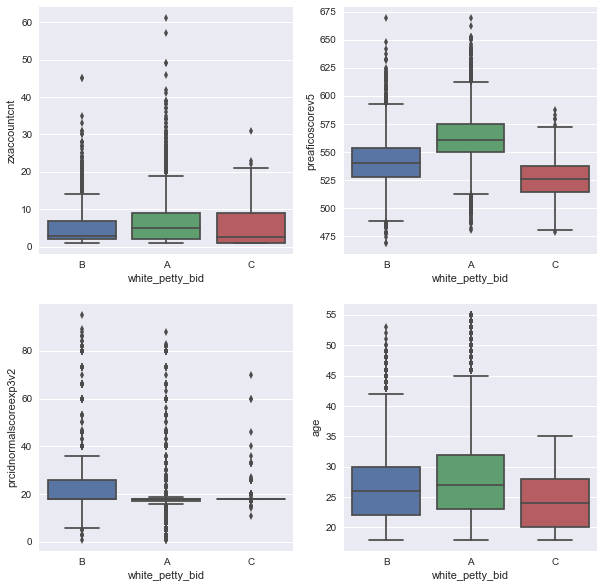

In [204]:
# 箱图分布
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

a = sns.boxplot(x='white_petty_bid', y='zxaccountcnt', data=data_set[data_set.odu_bid==1], ax=axs[0][0])
# axs[0][0].set_yscale('log')

b = sns.boxplot(x='white_petty_bid', y='preaficoscorev5', data=data_set[data_set.odu_bid==1], ax=axs[0][1])
# axs[0][1].set(ylim=(0, 0.5e8))

c = sns.boxplot(x='white_petty_bid', y='prcidnormalscoreexp3v2', data=data_set[data_set.odu_bid==1], ax=axs[1][0])
# axs[1][0].set(ylim=(0, 3e7))

d = sns.boxplot(x='white_petty_bid', y='age', data=data_set[data_set.odu_bid==1], ax=axs[1][1])

plt.show()


结论：<br>

* 多数超小额群体的部分模型分为空值，如preacustseg，preaficoscorev5等
* 由箱图可得，超小额群体的逾期用户年龄和preAsscoreV5分普遍较低

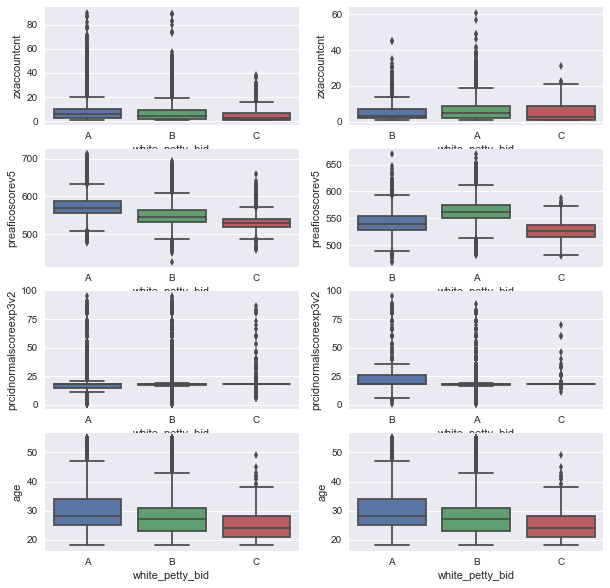

In [211]:
# 箱图分布
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

a0 = sns.boxplot(x='white_petty_bid', y='zxaccountcnt', data=data_set[data_set.action==1], ax=axs[0][0])
a1 = sns.boxplot(x='white_petty_bid', y='zxaccountcnt', data=data_set[data_set.odu_bid==1], ax=axs[0][1])
# axs[0][0].set_yscale('log')

b0 = sns.boxplot(x='white_petty_bid', y='preaficoscorev5', data=data_set[data_set.action==1], ax=axs[1][0])
b1 = sns.boxplot(x='white_petty_bid', y='preaficoscorev5', data=data_set[data_set.odu_bid==1], ax=axs[1][1])
# axs[0][1].set(ylim=(0, 0.5e8))

c0 = sns.boxplot(x='white_petty_bid', y='prcidnormalscoreexp3v2', data=data_set[data_set.action==1], ax=axs[2][0])
c1 = sns.boxplot(x='white_petty_bid', y='prcidnormalscoreexp3v2', data=data_set[data_set.odu_bid==1], ax=axs[2][1])
# axs[1][0].set(ylim=(0, 3e7))

d0 = sns.boxplot(x='white_petty_bid', y='age', data=data_set[data_set.action==1], ax=axs[3][0])
d1 = sns.boxplot(x='white_petty_bid', y='age', data=data_set[data_set.action==1], ax=axs[3][1])

plt.show()


结论：<br>

* 虽然超小额群体的逾期用户年龄和preAsscoreV5分普遍较低，但是趋势与大盘一致

## 趋势性分析

In [13]:
# 首先构建时间变量
from datetime import datetime, date, time
from time import strftime, localtime

apply_time=data_set['apply_time'].astype(str)
apply_day=[]
for i in apply_time:
    a_1=datetime.strptime(i,"%Y%m%d%H%M%S").strftime("%m-%d")
    apply_day.append(a_1)

data_set['apply_dt']=apply_day
data_set['apply_dt']=data_set['apply_dt'].astype(object)

In [264]:
# 不同目标群体逾期人数时间分布
line_petty_df=data_set.pivot_table(values=['odu_bid'], index='apply_dt', columns='white_petty_bid', aggfunc=[np.sum])
# line_petty_df.plot()

# 时间趋势
fig, ax = plt.subplots(figsize=(12, 8))
labels = ['A','B','C']
lines = ax.plot( line_petty_df.values, lw=2)
interactive_legend = plugins.InteractiveLegendPlugin(lines, labels)
plugins.connect(fig, interactive_legend)

mpld3.display()

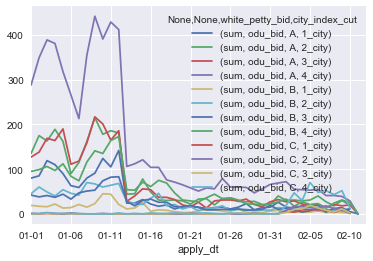

In [276]:
# 不同目标群体逾期人数时间分布
city_petty_df=data_set.pivot_table(values=['odu_bid'], index='apply_dt', columns=['white_petty_bid','city_index_cut'], aggfunc=[np.sum])
city_petty_df.plot()

## 相关性分析

* 对于连续型变量，考虑不同群体下变量间的相关性

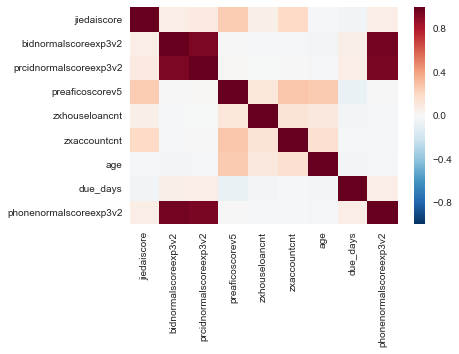

In [17]:
# 查看变量间的相关性
corr_data=data_set[data_set.petty_bid==1][['white_petty_bid','jiedaiscore','bidnormalscoreexp3v2','prcidnormalscoreexp3v2','preaficoscorev5','zxhouseloancnt','zxaccountcnt','age','due_days','phonenormalscoreexp3v2']]
sns.heatmap(corr_data.corr())

思考：

* 超小额群体中，某些变量存在相关性，通过这些有相关性的变量能否从非白群体中定位超小额用户呢？

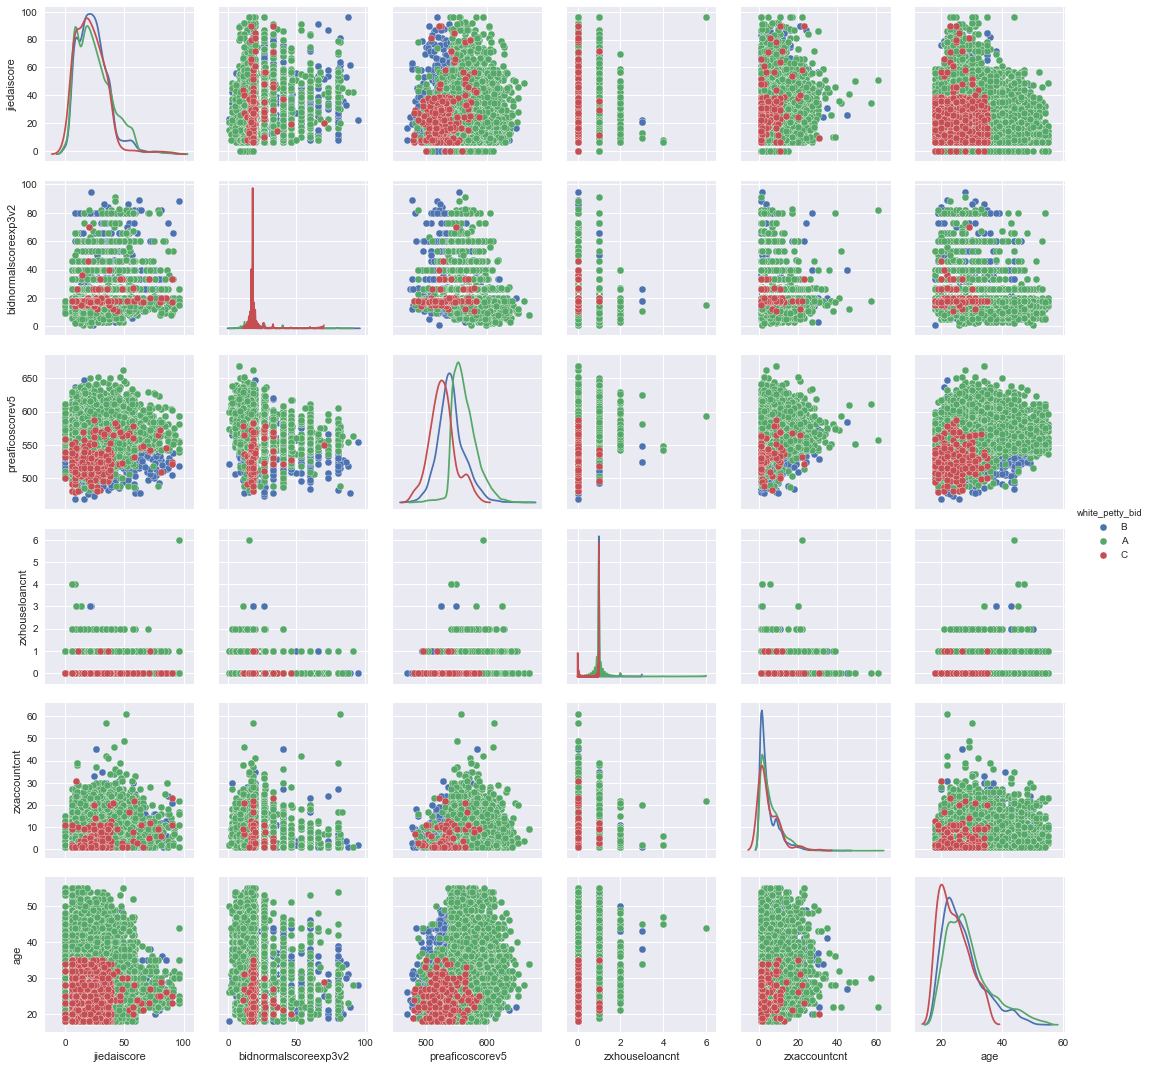

In [49]:
# 筛选非白群体
sns_data=data_set[data_set.odu_bid==1][['white_petty_bid','jiedaiscore','bidnormalscoreexp3v2','preaficoscorev5','zxhouseloancnt','zxaccountcnt','age']]
sns.pairplot(sns_data, hue='white_petty_bid', diag_kind='kde')

结论：

* C客群整体在变量preaficoscorev5，zxhouseloancnt分布偏低

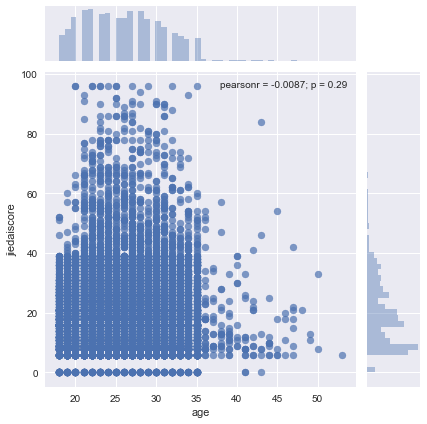

In [37]:
# 用于查看多遍量分布
petty_data=data_set[data_set.petty_bid==1][['age','jiedaiscore']]
plt.figure()
grid = sns.jointplot(petty_data['age'], petty_data['jiedaiscore'], alpha=0.7)
# grid.ax_joint.set_aspect('equal')

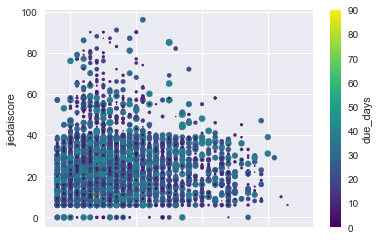

In [48]:
# 用于查看多遍量分布
petty_data=data_set[data_set.white_petty_bid!='A'][['due_days','age','jiedaiscore']]
# 颜色(c)和大小(s)有 due_days 列的数据决定
ax = petty_data.plot('age', 'jiedaiscore', kind='scatter',
        c='due_days', s=petty_data['due_days'], colormap='viridis')

结论：

* 什么样的超小额用户会用信：
* 什么样的超小额用户用信后比较容易逾期：


# 数据建模

## 准备数据

In [106]:
#加载所需库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [52]:
# 构建label
data_set.loc[(data_set.is_white==0)&(data_set.petty_bid==1)&(data_set.odu_bid==1),'label']='A'
data_set.loc[(data_set.is_white==0)&(data_set.petty_bid==1)&(data_set.odu_bid==0),'label']='B'
data_set.loc[(data_set.is_white==1)&(data_set.odu_bid==1),'label']='C'
data_set.loc[(data_set.is_white==1)&(data_set.odu_bid==0),'label']='D'

In [62]:
# 数据集扩充和抽样
data_1=pd.concat([data_set[data_set.label=='A']]*10)
data_2=data_set[data_set.label=='B'].sample(n=7000)
data_3=data_set[data_set.label=='C'].sample(n=7000)
data_4=data_set[data_set.label=='D'].sample(n=7000)

# 合并数据
data_set_new=pd.concat([data_1,data_2,data_3,data_4],ignore_index=True)

In [84]:
# 筛选入模变量
need_cols=['age','preaficoscorev5','zxaccountcnt','bidnormalscoreexp3v2','jiedaiscore']
df_x=data_set_new[need_cols]
# 缺失值填充
df_x=df_x.fillna(0)

In [85]:
# 数据归一化
model_data_x=df_x.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))   
# 筛选label
model_data_y=data_set_new['label']

In [86]:
# 合并数据集.axis=1表示横向合并数据
model_data=pd.concat([model_data_x,model_data_y],axis=1)

In [87]:
# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(model_data_x, model_data_y, test_size=0.3, random_state=0)
print('数据集样本数：{}，\n 训练集样本数：{}，\n 测试集样本数：{}'.format(len(model_data_x), len(X_train), len(X_test)))

数据集样本数：27710，
 训练集样本数：19397，
 测试集样本数：8313


## 模型建立及选择

In [ ]:
# 执行本地Python脚本
%load train_model.py

In [112]:
# 模型比较
model_name_param_dict = {'kNN':     [5, 10, 15],
                         'LR':      [0.01, 1, 100],
                         'SVM':     [0.01, 1, 100],}

results_df = pd.DataFrame(columns=['Accuracy (%)', 'Time (s)'],index=list(model_name_param_dict.keys()))

results_df.index.name = 'Model'
for model_name, param_range in model_name_param_dict.items():
        _, best_acc, mean_duration = train_model(X_train, y_train, X_test, y_test,param_range, model_name)
        results_df.loc[model_name, 'Accuracy (%)'] = best_acc * 100
        results_df.loc[model_name, 'Time (s)'] = mean_duration


训练kNN（k=5）...
耗时0.2520s
准确率：0.656
训练kNN（k=10）...
耗时0.1310s
准确率：0.634
训练kNN（k=15）...
耗时0.1190s
准确率：0.613
训练模型平均耗时0.1673s
()
训练SVM（C=0.01）...
耗时17.3730s
准确率：0.474
训练SVM（C=1）...
耗时16.1040s
准确率：0.557
训练SVM（C=100）...
耗时21.9760s
准确率：0.569
训练模型平均耗时18.4843s
()
训练Logistic Regression（C=0.01）...
耗时0.2560s
准确率：0.475
训练Logistic Regression（C=1）...
耗时0.3550s
准确率：0.509
训练Logistic Regression（C=100）...
耗时0.4380s
准确率：0.521
训练模型平均耗时0.3497s
()


In [113]:
results_df

,Accuracy (%),Time (s)
Model,,
kNN,65.6201,0.167333
SVM,56.9109,18.4843
LR,52.051,0.349667


## kNN

In [114]:
# 筛选最优的K值
k_range = range(1, 20)
acc_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acc_scores.append(knn.score(X_test, y_test))

# 建立模型
knn = KNeighborsClassifier(n_neighbors=3)
# 训练模型
knn.fit(X_train, y_train)
# 测试模型/预测
y_pred = knn.predict(X_test)

# 概率预测输出每个样本属于某一类的概率
# 输出的结果是array。其中p[i][j] 是通过概率 kNN 判断 X[i] 属于第 j 类的概率
y_prob=knn.predict_proba(X_test)

# 两种计算精度的方法
acc = accuracy_score(y_test, y_pred)

print('acc_ratio:', acc)

['D' 'B' 'C' ..., 'B' 'C' 'B']
('acc_ratio:', 0.65223144472512928)


In [123]:
# 忽略警告信息
import warnings
warnings.filterwarnings("ignore")

result_data=X_test
result_data['y_test']=y_test
result_data['y_pred']=y_pred
result_data.reset_index(drop=True).head(100)

,age,preaficoscorev5,zxaccountcnt,bidnormalscoreexp3v2,jiedaiscore,y_test,y_pred
0,0.351351,0.802292,0.163934,0.182796,0.500000,C,D
1,0.243243,0.846705,0.131148,0.354839,0.500000,C,B
2,0.351351,0.823782,0.163934,0.182796,0.354167,C,C
3,0.972973,0.822350,0.459016,0.064516,0.218750,D,D
4,0.405405,0.786533,0.098361,0.000000,0.156250,D,D
5,0.081081,0.000000,0.016393,0.000000,0.218750,B,A
6,0.270270,0.789398,0.032787,0.193548,0.239583,C,C
7,0.459459,0.000000,0.000000,0.000000,0.062500,A,A
8,0.378378,0.769341,0.000000,0.193548,0.250000,B,B
9,0.270270,0.792264,0.311475,0.000000,0.343750,B,D


# 结论

* 超小额用户